## <center>Gradient Descent, SGD, BatchedSGD and Ridge</center>  
### <center>Fu Shang</center>

In [1]:

import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import types
from sklearn.cross_validation import train_test_split

E:\Programming\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 2.1 Feature Normalization

In [2]:
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size (num_instances, num_features)
        test  - test set, a 2D numpy array of size (num_instances, num_features)
    Returns:
        train_normalized - training set after normalization
        test_normalized  - test set after normalization

    """
    # TODO
    num_feat=train.shape[1]
    num_ins_train=train.shape[0]
    num_ins_test=test.shape[0]
    coln=0
    while coln<num_feat:
        tmin,tmax=train[:,coln].min(),train[:,coln].max()
        if tmin==tmax: #delete constant feature
            np.delete(train,coln,axis=1)
            np.delete(test,coln,axis=1)
            num_feat-=1
            continue
        train[:,coln]=(train[:,coln]-tmin)/(tmax-tmin)
        test[:,coln]=(test[:,coln]-tmin)/(tmax-tmin)
        coln+=1
    return(train,test)

### 2.2 Gradient Descent Setup

#### 2.2.1 Objective function $J(\theta)$
$${J(\theta)}=\frac{1}{m}||X\theta-y||_{2}^{2}=\frac{1}{m}(\theta^{T}X^{T}X\theta-2\theta^{T}X^{T}y+y^{T}y)$$


#### 2.2.2 Square Loss Gradient
The expression for the gradient of J is:
$$\nabla{J(\theta)}=\frac{1}{m}\stackrel{m}{\sum_{\atop{i=1}}}{\nabla{(h_{\theta}(x_{i})-y_{i})^{2}}}$$

With the "designed matrix" and "response", we can get the expression of J in the format below:
$$\nabla{J(\theta)}=\frac{1}{m}\nabla||X\theta-y||_{2}^{2}=\frac{1}{m}(2X^{T}X\theta-2X^{T}y)$$

#### 2.2.3 First-order approximation

Ignore the quadratic terms of $\eta$, we can get the approximation:
$$J(\theta+\eta{h})-J(\theta)=\frac{2}{m}h^{T}\eta^{T}X^{T}(X\theta-y)=h^{T}\eta^{T}\nabla{J(\theta)}$$

#### 2.2.4 Update $\theta$
$$\theta_{k+1}=\theta_{k}-\eta\nabla{J(\theta_{k})}$$

#### 2.2.5 Modify the function <i>compute_square_loss</i>

In [3]:
def compute_square_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the square loss for predicting y with X*theta

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D array of size (num_features)

    Returns:
        loss - the square loss, scalar
    """
    loss = 0 #initialize the square_loss
    loss=np.mean(np.square(np.dot(X,theta)-y))
    return(loss)

#### 2.2.5 Modify the function <i>compute_square_loss_gradient</i>

In [4]:
def compute_square_loss_gradient(X, y, theta):
    """
    Compute gradient of the square loss (as defined in compute_square_loss), at the point theta.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    num_feat=X.shape[1]
    num_ins=X.shape[0] #row number of X
    grad=(2*np.dot(X.T,np.dot(X,theta))-2*np.dot(X.T,y))/X.shape[0]
    return(grad)

### 2.3 Gradient Checker

In [5]:
### Gradient Checker
#Getting the gradient calculation correct is often the trickiest part
#of any gradient-based optimization algorithm.  Fortunately, it's very
#easy to check that the gradient calculation is correct using the
#definition of gradient.
#See http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4):
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
    (e_1 = (1,0,0,...,0), e_2 = (0,1,0,...,0), ..., e_d = (0,...,0,1)

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
    ( J(theta + epsilon * e_i) - J(theta - epsilon * e_i) ) / (2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicate whether the gradient is correct or not

    """
    true_gradient = compute_square_loss_gradient(X, y, theta) #the true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    for i in range(num_features):
        e=np.zeros(num_features)
        e[i]=1
        approx_grad[i]=(compute_square_loss(X,y,theta+epsilon*e)- \
                        compute_square_loss(X,y,theta-epsilon*e))/2*epsilon
    dist=np.sqrt(np.dot(approx_grad-true_gradient,approx_grad-true_gradient))
    if dist<tolerance:
        return(True)
    else:
        return(False)

In [6]:
def generic_gradient_checker(X, y, theta, objective_func, gradient_func, epsilon=0.01, tolerance=1e-4):
    """
    The functions takes objective_func and gradient_func as parameters. And check whether gradient_func(X, y, theta) returned
    the true gradient for objective_func(X, y, theta).
    Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
    """
    true_gradient = gradient_func(X, y, theta) #the true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    for i in range(num_features):
        e=np.zeros(num_features)
        e[i]=1
        approx_grad[i]=(objective_func(X,y,theta+epsilon*e)- \
                        objective_func(X,y,theta-epsilon*e))/2*epsilon
    dist=np.sqrt(np.dot(approx_grad-true_gradient,approx_grad-true_gradient))
    if dist<tolerance:
        return(True)
    else:
        return(False)

### 2.4 Batch Gradient Descent

#### 2.4.1 Complete <i>batch_gradient_descent</i>

In [7]:
####################################
#### Batch Gradient Descent
def batch_grad_descent(X, y, alpha=0.1, num_iter=1000, check_gradient=False):
    """
    In this question you will implement batch gradient descent to
    minimize the square loss objective

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        num_iter - number of iterations to run
        check_gradient - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - store the the history of parameter vector in iteration, 2D numpy array of size (num_iter+1, num_features)
                    for instance, theta in iteration 0 should be theta_hist[0], theta in ieration (num_iter) is theta_hist[-1]
        loss_hist - the history of objective function vector, 1D numpy array of size (num_iter+1)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist
    theta = np.zeros(num_features) #initialize theta
    loss_hist[0]=compute_square_loss(X,y,theta)
    for i in range(num_iter):
        grad_i=compute_square_loss_gradient(X,y,theta)
        theta=theta-alpha*grad_i
        theta_hist[i+1]=theta
        loss_hist[i+1]=compute_square_loss(X,y,theta)
        if check_gradient==True:
            grad_id=grad_checker(X,y,theta)
    return(theta,theta_hist,loss_hist)

#### 2.4.2 Experiment with the step size
Conclutions: Without the BLS step choosing strategy, a step size larger than 0.1 will cause diverge in the iteration. Under the premise of convergence, larger step size will make the gradient descent faster.

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


E:\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in square
  from ipykernel import kernelapp as app
E:\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in multiply
  app.launch_new_instance()


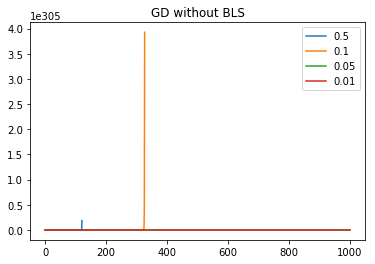

time: 0.3636469841003418


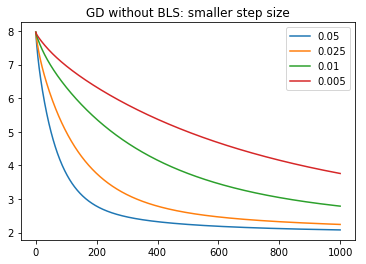

time: 0.3617432117462158


In [9]:
def main_gd():
    #Loading the dataset
    print('loading the dataset')

    df = pd.read_csv('data.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]

    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =100, random_state=10)

    print("Scaling all to [0, 1]")
    X_train, X_test = feature_normalization(X_train, X_test)
    X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
    X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1)))) # Add bias term

    #print(y_train)
    x=np.arange(1001)
    lines=locals()
    alpha=np.array([0.05,0.025,0.01,0.005])
    alpha_alter=np.array([0.5,0.1,0.05,0.01])
    fig2,ax2=plt.subplots()
    time_s=time.time()
    #GD without Backtracking Line Search
    time_s=time.time()
    for i in range(len(alpha)):
        (theta,theta_hist,loss_hist)=batch_grad_descent(X_train,y_train,alpha_alter[i])
        #print("theta:=",theta_hist,"loss:=",loss_hist)
        lines['line'+str(alpha_alter[i])],=ax2.plot(x,loss_hist)
    time_e=time.time()
    ax2.legend((alpha_alter),loc='upper right')
    ax2.set_title("GD without BLS")
    plt.show()
    fig3,ax3=plt.subplots()
    print('time:',time_e-time_s)
    #GD without Backtracking Line Search, another range step
    time_s=time.time()
    for i in range(len(alpha)):
        (theta,theta_hist,loss_hist)=batch_grad_descent(X_train,y_train,alpha[i])
        #print("theta:=",theta_hist,"loss:=",loss_hist)
        lines['line'+str(alpha[i])],=ax3.plot(x,loss_hist)
    time_e=time.time()
    ax3.legend((alpha),loc='upper right')
    ax3.set_title("GD without BLS: smaller step size")
    plt.show()
    print('time:',time_e-time_s)
if __name__ == "__main__":
    main_gd()
    

#### 2.4.3 Gradient Descent with Backtracking Line Search  
Conclusion: As shown above, with BLS, the BGD won't diverge with any initial step size, since BLS will justify the step size to guarantee the convergence. However, the algorithm won't make convergence faster, in terms of number of steps, compared with the best step size found manually, since it is a procedure to find best step size itself. Moreover, BLS will take extra calculating time, which is a big O of time compared with calculation of the gradient.

In [8]:
####################################
###Q2.4b: Implement backtracking line search in batch_gradient_descent
###Check http://en.wikipedia.org/wiki/Backtracking_line_search for details
#TODO
def batch_BLS_grad_descent(X, y, step=0.1, alpha=0.25, beta=0.8, num_iter=1000, check_gradient=False):
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist
    theta = np.zeros(num_features) #initialize theta
    loss_hist[0]=compute_square_loss(X,y,theta)
    for i in range(num_iter):
        step_temp=step
        grad_i=compute_square_loss_gradient(X,y,theta)
        loss_temp=compute_square_loss(X,y,theta)
        while compute_square_loss(X,y,theta-step_temp*grad_i)>loss_temp-alpha*step_temp*np.dot(grad_i,grad_i):
            step_temp=step_temp*beta
        theta=theta-step_temp*grad_i
        theta_hist[i+1]=theta
        loss_hist[i+1]=compute_square_loss(X,y,theta)
        if check_gradient==True:
            grad_id=grad_checker(X,y,theta)
    return(theta,theta_hist,loss_hist)

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


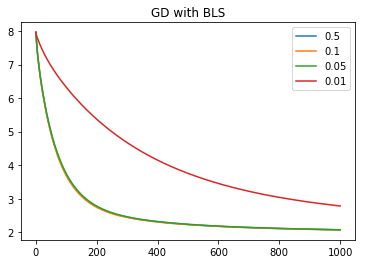

time: 1.4258356094360352


In [13]:
def main_gd_BLS():
    #Loading the dataset
    print('loading the dataset')

    df = pd.read_csv('data.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]

    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =100, \
                                                        random_state=10)

    print("Scaling all to [0, 1]")
    X_train, X_test = feature_normalization(X_train, X_test)
    X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
    X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1)))) # Add bias term

    x=np.arange(1001)
    lines=locals()
    alpha=np.array([0.05,0.025,0.01,0.005])
    alpha_alter=np.array([0.5,0.1,0.05,0.01])
    fig1,ax1=plt.subplots()
    time_s=time.time()
    #GD with Backtracking Line Search
    for i in range(len(alpha)):
        (theta,theta_hist,loss_hist)=batch_BLS_grad_descent(X_train,y_train,\
                                                            alpha_alter[i])
        lines['line'+str(alpha_alter[i])],=ax1.plot(x,loss_hist)
    time_e=time.time()
    ax1.legend((alpha_alter),loc='upper right')
    ax1.set_title("GD with BLS")
    plt.show()
    fig2,ax2=plt.subplots()
    print('time:',time_e-time_s)
if __name__ == "__main__":
    main_gd_BLS()
    

### 2.5 Ridge Regression

#### 2.5.1 Gradient of $J(\theta)$ and updating $\theta$
$$\nabla{J(\theta)}=\frac{1}{m}\nabla||X\theta-y||_{2}^{2}+\nabla\lambda\theta^{T}\theta=\frac{1}{m}(2X^{T}X\theta-2X^{T}y)+2\lambda\theta$$
$$\theta_{k+1}=\theta_{k}-\eta\nabla{J(\theta_{k})}=\frac{1}{m}(2X^{T}X\theta_{k}-2X^{T}y)+2\lambda\theta_{k}$$

#### 2.5.2 <i>compute_regularized_square_loss</i>

In [9]:
### 2.5.2

def compute_regularized_square_loss(X, y, theta, lambda_reg):
    loss = 0 #initialize the square_loss
    loss=np.mean(np.square(np.dot(X,theta)-y))+lambda_reg*np.dot(theta,theta)
    return(loss)

#### 2.5.3 <i>Compute the gradient of Regularized Batch Gradient Descent</i>

In [10]:
### 2.5.3 Compute the gradient of Regularized Batch Gradient Descent

def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    num_feat=X.shape[1]
    num_ins=X.shape[0] #row number of X
    grad=(2*np.dot(X.T,np.dot(X,theta))-2*np.dot(X.T,y))/num_ins+2*lambda_reg*theta
    return(grad)

#### 2.5.4 Unregularize the bias term 

Answer:

If we use a B>>1 in the d+1th dimension of X, the corresponding term in $\theta$ will turn to be very small after iterating a few times. Since the penalty term in Ridge Regression is used to decrease the Euclidean Norm of $\theta$, when a large B makes the d+1th term in $\theta$ far more smaller than its norm, the regularization effect on the bias term will be very little.

To make the regularization as week as we like, we could set a $\epsilon$ for which $\frac{1}{B}=\epsilon$, then the d+1th term of $\theta$ could satisfy $\frac{\theta_{d+1}}{||\theta||_{2}}<\epsilon$ in magnitude. Thus we could control the influence of regularization on B.

#### 2.5.5

Statement: If bias item in X is B, the corresponding bias coefficient in $\theta$ will satisfy ${\theta_{d+1}}=O(\frac{1}{B})<<{||\theta||_{2}}$ after regression, thus bias $B$'s influence on regularization of other parameters could be ignored.

Proof:  
Assume $\theta^{{d+1}\times{1}}=\left[ \begin{array}{ccc} \theta_{0}\\b\end{array}\right]$, $X^{m\times{(d+1)}}=\left[ \begin{array}{ccc} X_{0}&B\end{array}\right]$, $y^{m\times1}$

With matrix partition multiplication, we can get:  
$$J(\theta)=||X_{0}\theta_{0}+Bb-y||_{2}+\lambda{\theta}_{0}^{T}\theta_{0}+\lambda{b}^{T}{b}\\
=\underbrace{\theta_{0}^{T}X_{0}^{T}X_{0}\theta_{0}+y^{T}y-2\theta_{0}^{T}X_{0}^{T}y+\lambda\theta_{0}^{T}\theta_{0}}_{\Large ①}\\
+\underbrace{2\theta_{0}^{T}X_{0}^{T}Bb-2Bby}_{\Large②}+\underbrace{bBBb}_{\Large③}$$  
In the beginning, since $||X_{0}||=O(1)$, $||\theta_{0}||=O(1)$, $||y||=O(1)$, so $①=o(②)$, $②=o(③)$ as b starts as “1” and B>>1.  

So at early iteration process, item ③ will be minimized first before $\theta_{0}$ changes. Since $B>>1$ and is fixed, only $b$ could be minimized until $bBBb$ satisfies $||bBBb||=O(1)$.

In other words, at steady state, $b$ satisfies:  
$$|b|=O(\frac{1}{|B|})<<||\theta||_{2}$$  

Which means the bias item's influence on regularization parameter $\theta_{0}$ could be ignored.  

Overall, a very large B can make the influence of bias item on regularization as weak as we like.

#### 2.5.6

By testing different Bs, I found that B should remain to be 1 and the result will be more acceptible. Without BLS, a B larger than 1 performs huge influence on $\theta$ that the iteration starts diverge at the early steps. In order to apply the theory proved above as an algorithm, the strategy of choosing step size and $\lambda$ should also be changed according to B. So I used Ridge Regression with BLS, and the result also shows B=1 gives fastest converge speed to the algorithm.

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


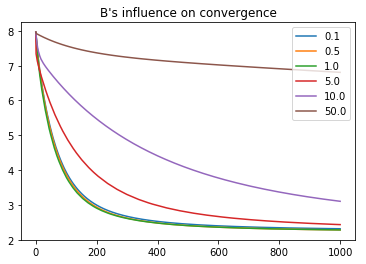

In [45]:
def main_Btest():
    #Loading the dataset
    print('loading the dataset')

    df = pd.read_csv('data.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]

    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =100, random_state=10)
    print("Scaling all to [0, 1]")
    X_train, X_test = feature_normalization(X_train, X_test)

    x=np.arange(1001)
    lines=locals()
    Bs=np.array([0.1,0.5,1,5,10,50])
    fig,ax=plt.subplots()
    for B in Bs: #Large number bias B
        X_train_temp = np.hstack((X_train, B*np.ones((X_train.shape[0], 1))))  # Add bias term
        X_test_temp = np.hstack((X_test, B*np.ones((X_test.shape[0], 1)))) # Add bias term
        (theta,theta_hist,loss_hist)=regularized_BLS_grad_descent(X_train_temp,y_train,lambda_reg=1e-2)
        #print("theta:=",theta_hist,"loss:=",loss_hist)
        lines['line'+str(B)],=ax.plot(x,loss_hist)
    ax.legend((Bs),loc='upper right')
    ax.set_title("B's influence on convergence")
    plt.show()
if __name__ == "__main__":
    main_Btest()
    

#### 2.5.7 Batch Gradient Descent with regularization term, with BLS

In [11]:
### 2.5.7 Batch Gradient Descent with regularization term, with BLS, loss without regularization

def regularized_BLS_grad_descent(X, y, step=0.1, alpha=0.25, beta=0.8, lambda_reg=1, num_iter=1000, with_BLS=True):
    """
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        numIter - number of iterations to run

    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size (num_iter+1, num_features)
        loss_hist - the history of loss function without the regularization term, 1D numpy array.
    """
    (num_instances, num_features) = (X.shape[0],X.shape[1])
    theta = np.zeros(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #Initialize loss_hist
    loss_hist[0]=compute_square_loss(X,y,theta)
    for i in range(num_iter):
        step_temp=step
        grad_i=compute_regularized_square_loss_gradient(X,y,theta,lambda_reg)
        if with_BLS==True:
            loss_temp=compute_regularized_square_loss(X,y,theta,lambda_reg)
            while compute_regularized_square_loss(X,y,theta-step_temp*grad_i,lambda_reg)>\
            loss_temp-alpha*step_temp*np.dot(grad_i,grad_i):
                step_temp=step_temp*beta
        theta=theta-step_temp*grad_i
        theta_hist[i+1]=theta
        loss_hist[i+1]=compute_square_loss(X,y,theta)
    return(theta,theta_hist,loss_hist)

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


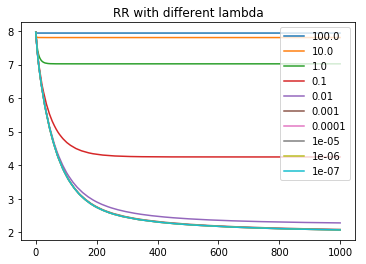

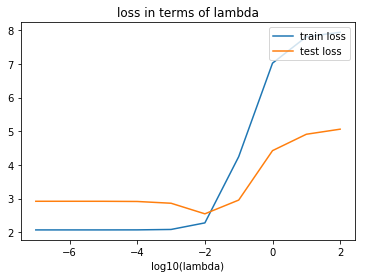

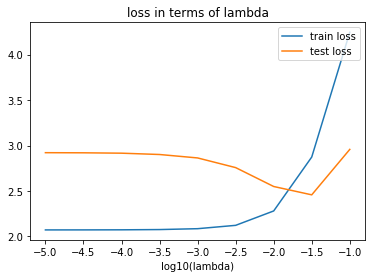

time: 7.456821441650391


In [71]:
def main_RR_lambda():
    #Loading the dataset
    print('loading the dataset')

    df = pd.read_csv('data.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]

    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =100, random_state=10)

    print("Scaling all to [0, 1]")
    B=1 #Large number bias B
    X_train, X_test = feature_normalization(X_train, X_test)
    X_train = np.hstack((X_train, B*np.ones((X_train.shape[0], 1))))  # Add bias term
    X_test = np.hstack((X_test, B*np.ones((X_test.shape[0], 1)))) # Add bias term

    #print(y_train)
    x=np.arange(1001)
    lines=locals()
    lambda_reg=np.array([100,10,1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7])
    lambda_reg_2=np.array([1e-1,np.sqrt(10)*1e-2,1e-2,np.sqrt(10)*1e-3,1e-3,np.sqrt(10)*1e-4,1e-4,\
                           np.sqrt(10)*1e-5,1e-5])
    #lambda_reg=np.array([0.00000000001,0.000000000000001])
    fig,ax=plt.subplots()
    time_s=time.time()
    loss_hist_lambda=np.zeros(len(lambda_reg))
    loss_hist_lambda_test=np.zeros(len(lambda_reg))
    theta_1=np.zeros((len(lambda_reg),X_train.shape[1]))
    for i in range(len(lambda_reg)):
        (theta,theta_hist,loss_hist)=regularized_BLS_grad_descent(X_train,y_train,step=0.1,\
                                                                  lambda_reg=lambda_reg[i],with_BLS=True)
        #print("theta:=",theta_hist,"loss:=",loss_hist)
        loss_hist_lambda[i]=loss_hist[-1]
        loss_hist_lambda_test[i]=compute_square_loss(X_test,y_test,theta)
        theta_1[i,:]=theta
        lines['line'+str(lambda_reg[i])],=ax.plot(x,loss_hist)
    time_e=time.time()
    ax.legend((lambda_reg),loc='upper right')
    ax.set_title('RR with different lambda')
    plt.show()
    fig2,ax2=plt.subplots()
    lines['train loss ITO lambda'],=ax2.plot(np.log10(lambda_reg),loss_hist_lambda)
    lines['test loss ITO lambda'],=ax2.plot(np.log10(lambda_reg),loss_hist_lambda_test)
    ax2.legend(('train loss','test loss'),loc='upper right')
    #ax2.set_xlim((np.log(lambda_reg)))
    ax2.set_title('loss in terms of lambda')
    ax2.set_xlabel('log10(lambda)')
    plt.show()
    loss_hist_lambda_2=np.zeros(len(lambda_reg_2))
    loss_hist_lambda_2_test=np.zeros(len(lambda_reg_2))
    theta_2=np.zeros((len(lambda_reg_2),X_train.shape[1]))
    for i in range(len(lambda_reg_2)):
        (theta,theta_hist,loss_hist)=regularized_BLS_grad_descent(X_train,y_train,\
                                                                  step=0.1,lambda_reg=lambda_reg_2[i],with_BLS=True)
        #print("theta:=",theta_hist,"loss:=",loss_hist)
        loss_hist_lambda_2[i]=loss_hist[-1]
        loss_hist_lambda_2_test[i]=compute_square_loss(X_test,y_test,theta)
        theta_2[i,:]=theta
    fig3,ax3=plt.subplots()
    lines['Train loss ITO lambda'],=ax3.plot(np.log10(lambda_reg_2),loss_hist_lambda_2)
    lines['test loss ITO lambda'],=ax3.plot(np.log10(lambda_reg_2),loss_hist_lambda_2_test)
    ax3.legend(('train loss','test loss'),loc='upper right')
    #ax2.set_xlim((np.log(lambda_reg)))
    ax3.set_title('loss in terms of lambda')
    ax3.set_xlabel('log10(lambda)')
    plt.show()
    print('time:',time_e-time_s)
if __name__ == "__main__":
    main_RR_lambda()
    

#### 2.5.8

I will choose $\theta$ obtained from $\lambda=10^{-1.5}$. Although this choice might not come up with a minimum train loss, but the test loss is lower than other $\theta$ values.

### 2.6 Stochastic Gradient Descent

#### 2.6.1  
One possible expression for $f_{i}(\theta)$ could be:
$$f_{i}(\theta)=(h_{\theta}(x_{i})-y_{i})^{2}+\lambda{\theta}^{T}\theta$$

For the second item, since it will be added m times then divided by m, it will remain $\lambda{\theta}^{T}\theta$ in $J(\theta)$.

#### 2.6.2  
Proof:

$J(\theta)=\frac{1}{m}\sum_{i=1}^{m}f_{i}(\theta) \Rightarrow \nabla{J(\theta)}=\frac{1}{m}{\sum_{i=1}^{m}}\nabla{f_{i}(\theta)}$

Since $\nabla{f(\theta)}$ satisfies uniform distribution, the possibility of choosing $f_{i}(\theta)$ in one selection is $\frac{1}{m}$. So $E[\nabla{f_{i}(\theta)}]=\sum_{i=1}^{m}P(\nabla{f_{i}}(\theta))\nabla{f_{i}{\theta}}=\frac{1}{m}{\sum_{i=1}^{m}}\nabla{f_{i}(\theta)}$

In summary, $\nabla{J(\theta)}=\frac{1}{m}{\sum_{i=1}^{m}}\nabla{f_{i}(\theta)}$

#### 2.6.3 

<center>$\theta_{j,k+1}=\theta_{j,k}-\eta\nabla{f_{k}(\theta_{j,k})}$ if $k<m$</center>

<center>$\theta_{j+1,1}=\theta_{j,k}-\eta\nabla{f_{k}(\theta_{j,k})}, k\Rightarrow1$ if $k=m$</center>
    
In which $\nabla{f_{k}}(\theta_{j,k})=2X[k]^{T}X[k]\theta-2X[k]^{T}y[k]+2\lambda{\theta}$

#### 2.6.4 Implement <i>stochastic_grad_descent</i>

In [12]:
### Stochastic Gradient Descent
def stochastic_grad_descent(X, y, alpha=0.1, batch_size=1, lambda_reg=1, num_iter=1000, sample_loss=False):
    """
    In this question you will implement stochastic gradient descent with a regularization term

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - string or float. step size in gradient descent
                NOTE: In SGD, it's not always a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every iteration is alpha.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t)
                if alpha == "1/t", alpha = 1/t
        lambda_reg - the regularization coefficient
        num_iter - number of epochs (i.e number of times) to go through the whole training set

    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size (num_iter, num_instances, num_features)
        loss hist - the history of regularized loss function vector, 2D numpy array of size(num_iter, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta

    theta_hist = np.zeros((num_iter+1, num_instances, num_features))  #Initialize theta_hist
    loss_hist = np.zeros((num_iter+1, num_instances)) #Initialize loss_hist
    sign_alpha=0
    if type(alpha) is type('a'):
        if alpha=='1/sqrt(t)':
            sign_alpha=1
        elif alpha=='1/t':
            sign_alpha=2
        else:
            sign_alpha=5
    loss_hist[0]=compute_square_loss(X,y,theta)
    for i in range(num_iter): #How can I use switch in python :(
        if sign_alpha!=0:
            if sign_alpha==1:
                alpha=1/np.sqrt(i+2500)
            elif sign_alpha==2:
                alpha=1/(i+50)
            else:
                alpha=0.1/(1+0.1*lambda_reg*i+50)
        for j in range(num_instances+1-batch_size):
            if batch_size>1:
                grad_i=(2*np.dot(X[j:j+batch_size-1].T,np.dot(X[j:j+batch_size-1],theta))\
                        -2*np.dot(X[j:j+batch_size-1].T,y[j:j+batch_size-1]))/batch_size+2*lambda_reg*theta
            else:
                grad_i=(2*np.dot(X[j],np.dot(X[j],theta))\
                        -2*np.dot(X[j],y[j]))/batch_size+2*lambda_reg*theta
            theta=theta-alpha*grad_i
            theta_hist[i+1][j]=theta
            #loss_hist[i+1][j]=compute_square_loss(X[j:j+batch_size-1],y[j:j+batch_size-1],theta)
            if sample_loss==True:
                loss_hist[i+1][j]=(np.dot(X[j],theta)-y[j])**2
            else:
                loss_hist[i+1][j]=compute_square_loss(X[:],y[:],theta)
    return(theta,theta_hist,loss_hist)

#### 2.6.5 & 2.6.6 Different step sizes

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


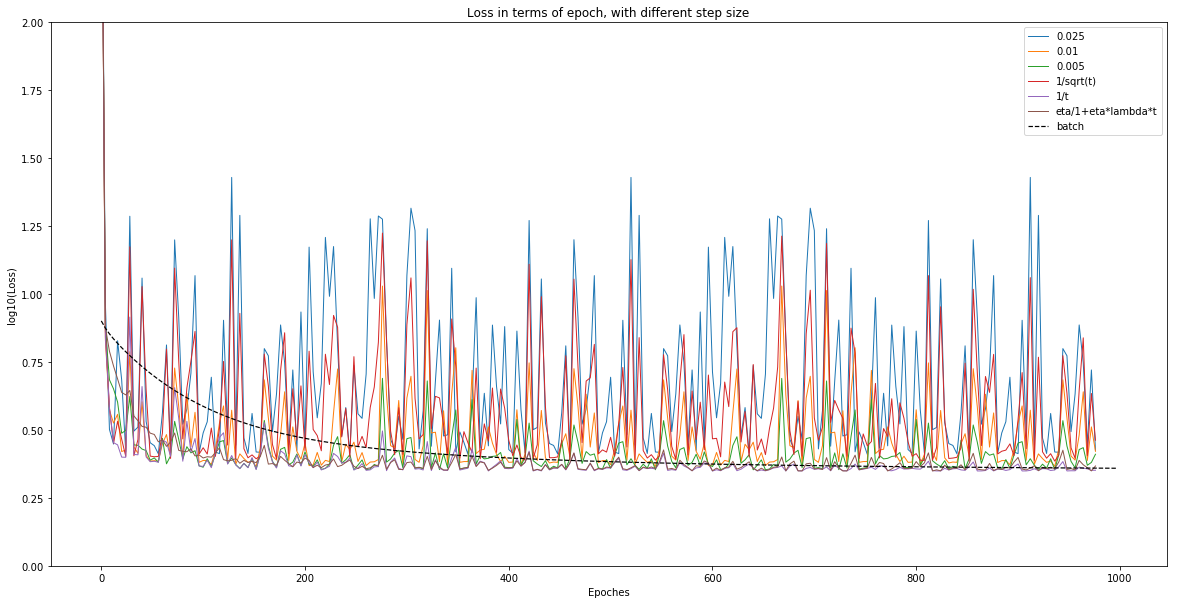

time: 42.85168647766113


In [15]:
def main_SGD():
    #Loading the dataset
    print('loading the dataset')

    df = pd.read_csv('data.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]

    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =100, random_state=10)

    print("Scaling all to [0, 1]")
    B=1 #Large number bias B
    X_train, X_test = feature_normalization(X_train, X_test)
    X_train = np.hstack((X_train, B*np.ones((X_train.shape[0], 1))))  # Add bias term
    X_test = np.hstack((X_test, B*np.ones((X_test.shape[0], 1)))) # Add bias term
    
    x=np.arange(1001)
    lines=locals()
    alpha=[0.025,0.01,0.005,'1/sqrt(t)','1/t','eta/1+eta*lambda*t']
    fig1,ax1=plt.subplots(figsize=(20,10))
    time_s=time.time()
    loss_hist_alpha=np.zeros(len(alpha))
    s=slice(1,-1,401)
    for i in range(len(alpha)):
        (theta,theta_hist,loss_hist)=stochastic_grad_descent(X_train,y_train,alpha=alpha[i],batch_size=1,\
                                                                  lambda_reg=1e-2,sample_loss=False)
        loss_hist_alpha[i]=loss_hist[-1,-1]
        loss_sample=loss_hist[0:1000,1:-1].reshape(-1)[s]
        lines['linestep'+str(alpha[i])],=ax1.plot(range(len(loss_sample)),np.log10(loss_sample),linewidth=1)
    (theta,theta_hist,loss_hist)=regularized_BLS_grad_descent(X_train,y_train,step=0.05,\
                                                                  lambda_reg=1e-2,with_BLS=False)
    loss_sample=loss_hist[slice(0,1000,4)]
    lines['linestep'+'batch'],=ax1.plot(range(len(loss_sample)),np.log10(loss_sample),'--',color='black',linewidth=1.2)
    time_e=time.time()
    alpha.append('batch')
    ax1.legend((alpha),loc='upper right')
    ax1.set_title('Loss in terms of epoch, with different step size')
    ax1.set_ylim([0,2])
    ax1.set_ylabel('log10(Loss)')
    ax1.set_xlabel('Epoches')
    plt.xticks([0,50,100,150,200,250], [0,200,400,600,800,1000])
    plt.show()
    print('time:',time_e-time_s)
if __name__ == "__main__":
    main_SGD()
    

Based on the loss in examples above, regularized gradient descent could get converged result with a fixed step size smaller than 0.025, but the result is with strong fluctuation. Generally, smaller step size results in smaller fluctuation. With advanced step strategy, the result will be better. Although with different initial t values, we can find some regularity that the $\frac{1}{t}$ and $\frac{\eta_{0}}{1+\eta_{0}\lambda{t}}$ step size converge better than fixed size examples as epoch number increase.

### 3 Risk Minimization

#### 3.1 Square Loss

(a) $a^{*}=E[y|x]$

(b) According to Law of Iterated Expectations, $E[X]=E[E[X|Y]]$. Since we know $E[(f^{*}(x)-y)^{2}|x]\le{E[(f(x)-y)^{2}|x]}$ for the same distribution of x and y on both sides of the inequality, we could get the expectation about x which is:

$$\sum{E[(f^{*}(x)-y)^{2}|x]*P(X=x)}\le{\sum{E[(f(x)-y)^{2}|x]*P(X=x)}}$$

which is:

$$E[(f^{*}(x)-y)^{2}]\le{E[(f(x)-y)^{2}]}$$

for any $f$.

#### 3.2 Median Loss

Proof:


for a given $x$ and any given $f(x)$, we could see the estimation as $E[|E(y|x)+b-y||x]$ in which $b$ is a bias. Since $f^{*}(x)$ is the median, which means $\int_{y=-\infty}^{f^{*}(x)}p(y|x)=\int_{y=f^{*}(x)}^{\infty}p(y|x)$, So b=0, so for any $f(x)\ne{f^{*}(x)}$, $E[|f^{*}(x)-y||x]\le{E[|f(x)-y||x]}$ holds for all $x$. Thus by applying the Law of Iterated Expectations, we get $E[|f^{*}(x)-y|]\le{E[|f(x)-y|]}$ which means $f^{*}(x)$ is the Bayes decision function.